In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

In [280]:
def binterval(k):
    '''takes apparent binding constent and builds lig series around it (2 log intervals on either end)'''
    low = (1/k)/100
    limit = (1/k)*100
    return dilser(low=low,limit=limit)

In [281]:
def lognuniform(low=0, high=1, size=None, base=np.exp(1)):
    return np.power(base, np.random.uniform(low, high, size))

In [282]:
def guessgen(length,lowmag=-3,himag=3,base=10):
    return tuple(lognuniform(low=lowmag,high=himag,base=base) for i in range(length))

In [283]:
def colroots(data,ligs): 
    holder = []
    for i in range(len(ligs)):
        temp = data[:,i]
        roots,counts = np.unique(temp,return_counts=True)
        posroots = roots[roots>0]
        poscounts = counts[roots>0]
        clctd = np.stack((posroots,poscounts),axis=1)
        clctd = clctd[(-1*clctd[:,1]).argsort()]
        holder.append(clctd[:3]) #only take top 3 (or fewer) guesses
    return holder

In [379]:
lig_concs = binterval(10)
lrng = lig_concs.shape[0]

In [380]:
def k2solv(var,parm,rtot,ltot):
    
    k1 = parm[0]
    k2 = parm[1]
    
    (L,R,RL,RLL) = var
    
    eq1 = (R + RL + RLL) - rtot
    eq2 = (L + RL + 2*RLL) - ltot
    eq3 = (k1*R*L) - RL
    eq4 = (k2*k1*R*L*L) - RLL
    
    return np.array([eq1,eq2,eq3,eq4])

In [400]:
parmk2 = np.array([10.,1.])

In [401]:
k2guesses = [guessgen(4) for i in range(100)]
resk2 = np.array([[optimize.root(k2solv,i,args=(parmk2,0.01,j),method='lm',options={'factor':0.1,'ftol':1e-14,'gtol':1e-14,'xtol':1e-14}).x for j in lig_concs] for i in k2guesses])

In [402]:
rootbag_k2 = [colroots(resk2[:,:,j],lig_concs) for j in range(4)]

In [403]:
dL = np.array([rootbag_k2[0][i][0][0] for i in range(lrng)])
dR = np.array([rootbag_k2[1][i][0][0] for i in range(lrng)])
dRL = np.array([rootbag_k2[2][i][0][0] for i in range(lrng)])
dRLL = np.array([rootbag_k2[3][i][0][0] for i in range(lrng)])

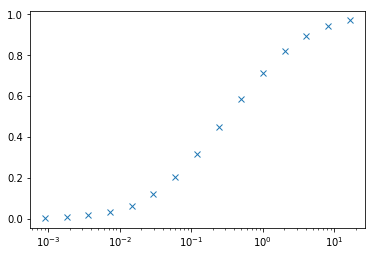

In [404]:
plt.semilogx(dL,((dRL + 2*dRLL)/(dR + dRL + dRLL))/2,'x')

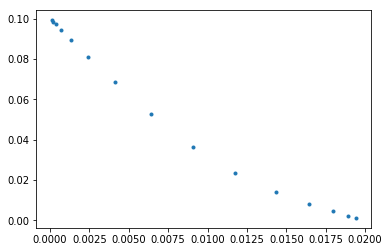

In [405]:
plt.plot((dRL + 2*dRLL),((dRL + 2*dRLL)/dL),'.')

In [399]:
lig_concs

array([  1.00000000e-03,   2.00000000e-03,   4.00000000e-03,
         8.00000000e-03,   1.60000000e-02,   3.20000000e-02,
         6.40000000e-02,   1.28000000e-01,   2.56000000e-01,
         5.12000000e-01,   1.02400000e+00,   2.04800000e+00,
         4.09600000e+00,   8.19200000e+00,   1.63840000e+01])

In [413]:
def avroots(data,ligs): 
    holder = []
    for i in range(len(ligs)):
        temp = data[:,i]
        roots,counts = np.unique(temp,return_counts=True)
        posroots = roots[roots>0]

    return posroots

In [414]:
[avroots(resk2[:,:,j],lig_concs) for j in range(4)]

[array([ 16.36458272]),
 array([  3.51785478e-06,   3.51785478e-06,   3.51785478e-06,
          3.51785478e-06,   2.50821375e+00,   2.50821375e+00,
          2.50821375e+00,   2.50821375e+00]),
 array([  5.75682256e-04,   5.75682256e-04,   2.13009978e+01,
          2.13009978e+01,   2.13009978e+01]),
 array([  9.42079989e-03,   9.42079989e-03,   9.42079989e-03,
          1.97700264e+01,   1.97700264e+01])]

In [439]:
resk2.shape

(100, 15, 4)

In [448]:
avroots = np.array([[np.mean(resk2[:,i,k][resk2[:,i,k]>0]) for i in range(lrng)] for k in range(4)])

In [449]:
dLAV = avroots[0] 
dRAV = avroots[1]
dRLAV = avroots[2]
dRLLAV = avroots[3]

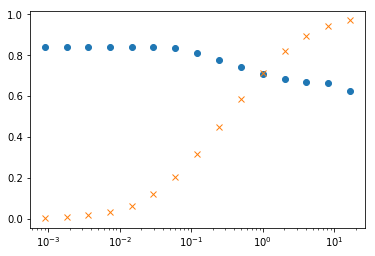

In [450]:
plt.semilogx(dLAV,((dRLAV + 2*dRLLAV)/(dRAV + dRLAV + dRLLAV))/2,'o')
plt.semilogx(dL,((dRL + 2*dRLL)/(dR + dRL + dRLL))/2,'x')

In [451]:
dL

array([  9.09687998e-04,   1.82055452e-03,   3.64573136e-03,
         7.30924799e-03,   1.46844471e-02,   2.95972655e-02,
         5.98973182e-02,   1.21604697e-01,   2.46956322e-01,
         5.00233517e-01,   1.00968155e+00,   2.03156547e+00,
         4.07805591e+00,   8.17311533e+00,   1.63645827e+01])

In [452]:
avroots[0]

array([  9.09687998e-04,   1.82055452e-03,   3.64573136e-03,
         7.30924799e-03,   1.46844471e-02,   2.95972655e-02,
         5.98973182e-02,   1.21604697e-01,   2.46956322e-01,
         5.00233517e-01,   1.00968155e+00,   2.03156547e+00,
         4.07805591e+00,   8.17311533e+00,   1.63645827e+01])

In [453]:
dR

array([  9.90977001e-03,   9.82088002e-03,   9.64701358e-03,
         9.31422413e-03,   8.70321412e-03,   7.66440551e-03,
         6.11676886e-03,   4.23025445e-03,   2.45131836e-03,
         1.17582445e-03,   4.69673555e-04,   1.59774431e-04,
         4.80570628e-05,   1.33203807e-05,   3.51785478e-06])

In [459]:
avroots[3]

array([ 0.19424093,  0.19445797,  0.19489245,  0.19576293,  0.19750931,
        0.20101989,  0.21032497,  0.22685556,  0.25561745,  0.33385549,
        0.48154137,  0.76028114,  1.38927274,  2.31506446,  3.60225819])

In [456]:
dRL

array([  9.01479884e-05,   1.78794475e-04,   3.51704200e-04,
         6.80799740e-04,   1.27801888e-03,   2.26845444e-03,
         3.66378051e-03,   5.14418811e-03,   6.05368568e-03,
         5.88186802e-03,   4.74220725e-03,   3.24592217e-03,
         1.95979389e-03,   1.08869008e-03,   5.75682256e-04])